#                                       CSE578 - Computer Vision

## Assignment - 2

### Name : Jeet Vora 
### Roll Number : 2019701006

### Location of inputs:
https://drive.google.com/open?id=1qtKZYv6xOxVNKqMkqaw7uAIjzET7m4TB

In [53]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import random
import math
import imutils
import scipy as sp
import scipy.signal
from scipy.signal import convolve2d as conv2d
import time
import warnings
warnings.filterwarnings('ignore')

# Image Mosaicing
1. Use any feature detector and descriptor (e.g. SIFT) to ﬁnd matches between two partially overlapping images. You can use inbuilt functions for this.
2. Estimate the homography matrix between the two images robustly.
3. Transform one of the images to the others reference frame using the homography matrix.
4. Stitch the two images together.
5. Repeat this for multiple images to produce a singly mosaic/panorama.

In [54]:
class Image_Mosaicing:

    def image_stitch(self, images, lowe_ratio=0.50, max_Threshold=5.0, match_status=False):

        #detect the features and keypoints from SIFT
        (imageB, imageA) = images
        (keypointsA, features_of_A) = self.Detect_keypoint_and_feature(imageA)
        (keypointsB, features_of_B) = self.Detect_keypoint_and_feature(imageB)

        #got the valid matched points
        Values = self.matchkeypoints(keypointsA, keypointsB, features_of_A, features_of_B, lowe_ratio, max_Threshold)

        if Values is None:
            return None

        #to get perspective of image using computed homography
        (matches, H, status) = Values
        result_image = self.getwarp_perspective(imageA,imageB,H)
        result_image[0:imageB.shape[0], 0:imageB.shape[1]] = imageB


        return result_image

    def getwarp_perspective(self,imageA,imageB,Homography):
        # getting warping perspective from images and homography
        width = imageA.shape[1] + imageB.shape[1]
        height = imageA.shape[0] + imageB.shape[0]
        result_image = cv2.warpPerspective(imageA, Homography, (width , height))
        return result_image

    def Detect_keypoint_and_feature(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # detect and extract features from the image
        descriptors = cv2.xfeatures2d.SIFT_create()
        (keypoints, features) = descriptors.detectAndCompute(image, None)

        keypoints = np.float32([i.pt for i in keypoints])
        return (keypoints, features)

    def Compute_Homography(self,pointsA,pointsB,max_Threshold):
        #to compute homography using points in both images
        
        #H = self.ransac(pointsA,pointsB, max_Threshold, dist=5)
        #status = True
        (H, status) = cv2.findHomography(pointsA, pointsB, cv2.RANSAC, max_Threshold)

        return (H,status)

    def matchkeypoints(self, keypointsA, keypointsB, featuresA, featuresB,lowe_ratio, max_Threshold):

        match_instance = cv2.DescriptorMatcher_create("BruteForce")
        all_matches = match_instance.knnMatch(featuresA, featuresB, 2)
        
        valid_matches = []

        for val in all_matches:
            if (len(val) == 2 and val[0].distance < val[1].distance * lowe_ratio):
                valid_matches.append((val[0].trainIdx, val[0].queryIdx))

        if (len(valid_matches) > 4):
            # construct the two sets of points
            pointsA = np.float32([keypointsA[i] for (_,i) in valid_matches])
            pointsB = np.float32([keypointsB[i] for (i,_) in valid_matches])

            (H, status) = self.Compute_Homography(pointsA, pointsB, max_Threshold)
            
            return (valid_matches, H, status)
        else:
            return None
        
    def ransac(self, src_pts,dst_pts, thresh, dist=5):
        maxInliers = []
        finalH = None
        for i in range(500):
            r4 =  np.random.randint(0,len(src_pts),4)
            randomFour = []
            for x in r4:
                randomFour.append((src_pts[x,0,:], dst_pts[x,0,:] ))
            
            h = self.find_homogrpahy(randomFour)
        
            inliers = []

            for i in range(len(src_pts)):
                d = self.geometricDistance( src_pts[i,0,:], dst_pts[i,0,:] , h)
                if d < dist:
                    inliers.append(cr)
        
            if len(inliers) > len(maxInliers):
                maxInliers = inliers
                finalH = h
        
            if len(maxInliers) > len(src_pts)*thresh:
                break
        
        return finalH
    
    def find_homogrpahy(self, correspondences):
        aList = []
        for corr in correspondences:
        
            x1 = corr[0]
            x2 = corr[1]
            a2 = [0, 0, 0, -x1[0], -x1[1], -1, x2[1] *x1[0] , x2[1]*x1[1] , x2[1] ]
            a1 = [ -x1[0], -x1[1], -1,  0, 0, 0,  x2[0] * x1[0], x2[0] * x1[1], x2[0] ]
            aList.append(a1)
            aList.append(a2)

        matrixA = np.array(aList)

        u, d, v = np.linalg.svd(matrixA)

        h = np.reshape(v[8], (3, 3))

        h = h/h[2,2]
        return h
    
    def geometricDistance(self, src,dst, h):
        p1 = np.array([src[0],src[1], 1]).T
        estimatep2 = np.dot(h, p1)
        estimatep2 = estimatep2/estimatep2[2]

        p2 = np.matrix([ dst[0], dst[1], 1]).T
        error = p2 - estimatep2
        return np.linalg.norm(error)

        
def Panaroma_processing(images_glob):
    no_of_images = len(images_glob)
    images = []
    for filename in images_glob:
        images.append(cv2.imread(filename))
    
    #We need to modify the image resolution and keep our aspect ratio use the function imutils
    
    for i in range(no_of_images):
        images[i] = imutils.resize(images[i], width=500)
    
    for i in range(no_of_images):
        images[i] = imutils.resize(images[i], height=500)
    
        
    panaroma = Image_Mosaicing()
    if no_of_images==2:
        result = panaroma.image_stitch([images[0], images[1]], match_status=True)
    else:
        result = panaroma.image_stitch([images[no_of_images-2], images[no_of_images-1]], match_status=True)
        for i in range(no_of_images - 2):
            result = panaroma.image_stitch([images[no_of_images-i-3],result], match_status=True)
    
    return result

Text(0.5, 1.0, 'Image Mosaicing')

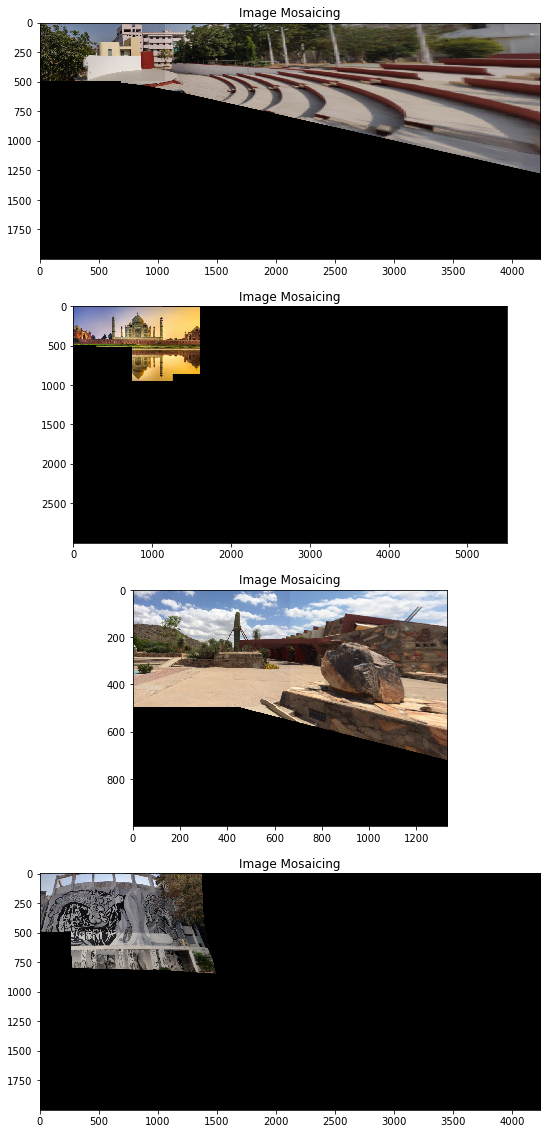

In [55]:
images1 = glob.glob('input_data/image_mosaicing/img1_*.jpg')
result1 = Panaroma_processing(images1)

images2 = glob.glob('input_data/image_mosaicing/img2_*.png')
result2 = Panaroma_processing(images2)

images3 = glob.glob('input_data/image_mosaicing/img3_*.png')
result3 = Panaroma_processing(images3)

images4 = glob.glob('input_data/image_mosaicing/img5_*.jpg')
result4 = Panaroma_processing(images4)

f, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(20,20))
ax1.imshow(cv2.cvtColor(result1, cv2.COLOR_RGB2BGR))
ax1.set_title('Image Mosaicing')

ax2.imshow(cv2.cvtColor(result2, cv2.COLOR_RGB2BGR))
ax2.set_title('Image Mosaicing')

ax3.imshow(cv2.cvtColor(result3, cv2.COLOR_RGB2BGR))
ax3.set_title('Image Mosaicing')

ax4.imshow(cv2.cvtColor(result4, cv2.COLOR_RGB2BGR))
ax4.set_title('Image Mosaicing')

Basic Procedure 
1. Take a sequence of images from the same position. 
2. Rotate the camera about its optical center. 
3. Robustly compute the homography transformation between second image and first. 
4. Transform (warp) the second image to overlap with first. 
5. Blend the two together to create a mosaic. 
6. If there are more images, repeat

For calculating we are using RANSAC algorithm
For each iteration we randomly take 4 variables as Homography is a 3x3 matrix as the camera center is assumed to be same for each image. Our objective is the minimize the distance predicted(after transformation using homography) and the real image coordinates. Hence we have a formulation similar to DLT. We take the least eigen value vector as the homography in each iteration. Iteration with least error is the most accurate homography matrix

# Stereo Correspondences
1. Perform Intensity Window-based correlation on the given pair of images.
2. Rectify the pairs of images and with these new images, repeat step 1.
3. Compare with Greedy Matching and Dynamic programming solution for Stereo Correspondence on the rectiﬁed images

In [56]:
import numpy as np
import cv2

def translaton(image, shape):
    # translation of I(x,y)
    step = round((shape[0]-1)/2)
    shifted = []
    for i in range(0, step+1):
        for j in range(0, step+1):
            if i==0 and j==0:
                M1 = np.float32([[1, 0, i], [0, 1, j]])
                shifted.append(cv2.warpAffine(image, M1, (image.shape[1], image.shape[0])))
            elif i==0 and j!=0:
                M1 = np.float32([[1, 0, i], [0, 1, j]])
                M2 = np.float32([[1, 0, i], [0, 1, -j]])
                shifted.append(cv2.warpAffine(image, M1, (image.shape[1], image.shape[0])))
                shifted.append(cv2.warpAffine(image, M2, (image.shape[1], image.shape[0])))
            elif i!=0 and j==0:
                M1 = np.float32([[1, 0, i], [0, 1, j]])
                M2 = np.float32([[1, 0, -i], [0, 1, j]])
                shifted.append(cv2.warpAffine(image, M1, (image.shape[1], image.shape[0])))
                shifted.append(cv2.warpAffine(image, M2, (image.shape[1], image.shape[0])))
            else:
                M1 = np.float32([[1, 0, i], [0, 1, j]])
                M2 = np.float32([[1, 0, -i], [0, 1, -j]])
                M3 = np.float32([[1, 0, -i], [0, 1, j]])
                M4 = np.float32([[1, 0, i], [0, 1, -j]])
                shifted.append(cv2.warpAffine(image, M1, (image.shape[1], image.shape[0])))
                shifted.append(cv2.warpAffine(image, M2, (image.shape[1], image.shape[0])))
                shifted.append(cv2.warpAffine(image, M3, (image.shape[1], image.shape[0])))
                shifted.append(cv2.warpAffine(image, M4, (image.shape[1], image.shape[0])))

    return np.array(shifted)


def img_sub_avg(img_shifted, avg_img):
    #I(x,y)-avg(I(x,y))
    len, height, width = img1_shifted.shape
    tmp_ncc1 = np.zeros([len, height, width])
    for i in range(len):
        tmp_ncc1[i] = img_shifted[i] - avg_img
    
    return tmp_ncc1

def NCC(img1_sub_avg,img2_sub_avg, threshold, max_d):
    # Calculating normalized cross correlation
    
    len, height, width = img1_sub_avg.shape
    thershould_shifted = np.zeros([len, height, width])
    ncc_max = np.zeros([height, width])
    ncc_d = np.zeros([height, width])
    for j in range(3, max_d):
        tmp_ncc1 = np.zeros([height, width])
        tmp_ncc2 = np.zeros([height, width])
        tmp_ncc3 = np.zeros([height, width])
        for k in range(len):
            M1 = np.float32([[1, 0, -j - 1], [0, 1, 0]])
            thershould_shifted[k] = cv2.warpAffine(img1_sub_avg[k], M1, (img1_sub_avg.shape[2], img1_sub_avg.shape[1]))
        for i in range(len):
            tmp_ncc1 += (img2_sub_avg[i])*(thershould_shifted[i])
            tmp_ncc2 += pow(img2_sub_avg[i], 2)
            tmp_ncc3 += pow(thershould_shifted[i], 2)

        tmp_ncc2 = tmp_ncc2*tmp_ncc3
        tmp_ncc2 = np.sqrt(tmp_ncc2)
        tmp_ncc4 = tmp_ncc1/tmp_ncc2
        for m in range(height):
            for n in range(width):
                if tmp_ncc4[m, n] > ncc_max[m ,n] and tmp_ncc4[m, n] > threshold:
                    ncc_max[m, n] = tmp_ncc4[m, n]
                    ncc_d[m , n] = j
                    
    return ncc_max, ncc_d

Text(0.5, 1.0, 'Depth')

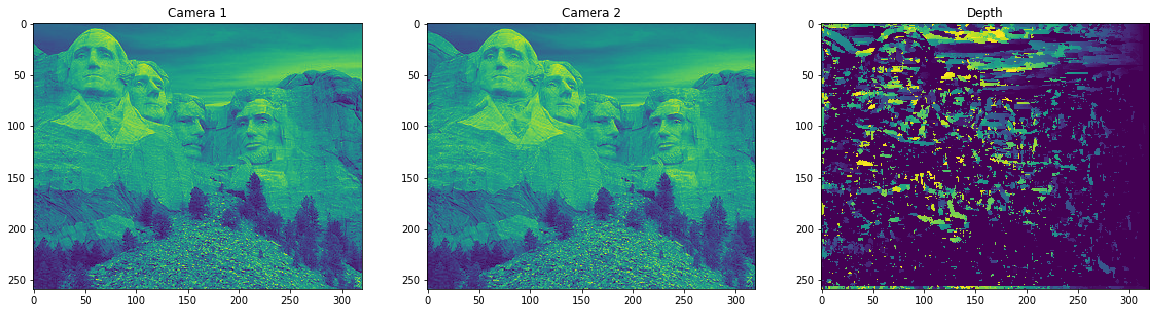

In [57]:
image = cv2.imread('input_data/stereo_images/2.jpg',cv2.CV_8UC1)
height, width = image.shape
img1 = image[:,:width//2]
img2 = image[:,width//2:]
rows, cols = img1.shape

k = 7
disparity = np.zeros([rows, cols])
NCC_value = np.zeros([rows, cols])
deeps = np.zeros([rows, cols])

avg_img1 = cv2.blur(img1, (k, k))
avg_img2 = cv2.blur(img2, (k, k))
fimg1 = img1.astype(np.float32)
fimg2 = img2.astype(np.float32)
avg_img1 = avg_img1.astype(np.float32)
avg_img2  = avg_img2.astype(np.float32)
img1_shifted = translaton(fimg1, [k, k])
img2_shifted = translaton(fimg2, [k, k])
img1_sub_avg = img_sub_avg(img1_shifted, avg_img1)
img2_sub_avg = img_sub_avg(img2_shifted, avg_img2)
ncc_max, ncc_d = NCC(img1_sub_avg,img2_sub_avg, threshold = 0.5, max_d = 128)

disp = cv2.normalize(ncc_d, ncc_d, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,
                      dtype=cv2.CV_8U)

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,20))
ax1.imshow(img1)
ax1.set_title('Camera 1')

ax2.imshow(img2)
ax2.set_title('Camera 2')

ax3.imshow(disp)
ax3.set_title('Depth')

### Rectification :
1. Project each image onto same plane, which is parallel to the epipole
2. Resample lines (and shear/stretch) to place lines in correspondence, and minimize distortion

In [58]:
def Detect_keypoint_and_feature(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect and extract features from the image
    descriptors = cv2.xfeatures2d.SIFT_create()
    (keypoints, features) = descriptors.detectAndCompute(image, None)

    keypoints = np.float32([i.pt for i in keypoints])
    return (keypoints, features)

def matching_points(im1,im2):
    (keypointsA, features_of_A) = Detect_keypoint_and_feature(im1)
    (keypointsB, features_of_B) = Detect_keypoint_and_feature(im2)
    
    match_instance = cv2.DescriptorMatcher_create("BruteForce")
    all_matches = match_instance.knnMatch(features_of_A, features_of_B, 2)
            
    valid_matches = []
    
    for val in all_matches:
        if (len(val) == 2 and val[0].distance < val[1].distance * 0.50):
            valid_matches.append((val[0].trainIdx, val[0].queryIdx))
    
        if (len(valid_matches) > 4):
        # construct the two sets of points
            pointsA = np.float32([keypointsA[i] for (_,i) in valid_matches])
            pointsB = np.float32([keypointsB[i] for (i,_) in valid_matches])
            
    return pointsA,pointsB

def Rectify_Stereo(im1,im2):
    # Rectifying Images using Fundamental matrix
    pointsA,pointsB = matching_points(im1,im2)
    F, mask = cv2.findFundamentalMat(pointsA, pointsB, cv2.FM_RANSAC, 3, 0.99)
    row,col = im1.shape[0],im1.shape[1]
    retval, H1, H2 = cv2.stereoRectifyUncalibrated(pointsA, pointsB, F, (row,col))
    result_image1 = cv2.warpPerspective(im1, H1, (row , col))
    result_image2 = cv2.warpPerspective(im2, H2, (row , col))
    
    return result_image1, result_image2

Text(0.5, 1.0, 'Rectified Image 2')

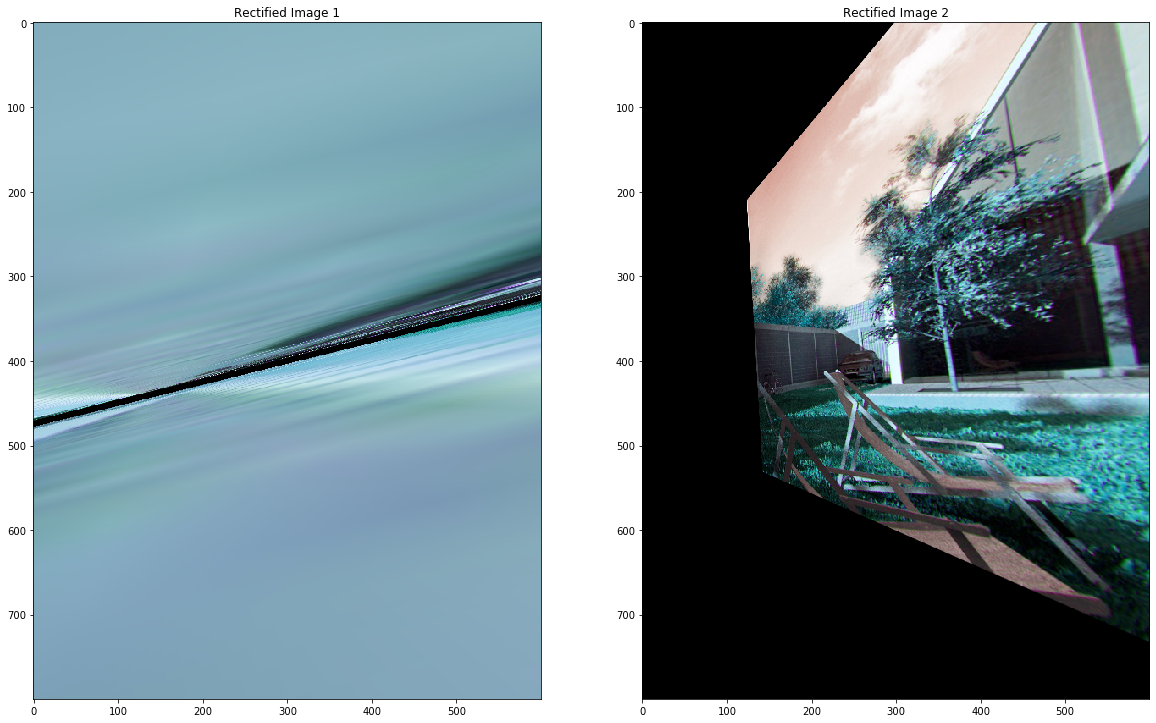

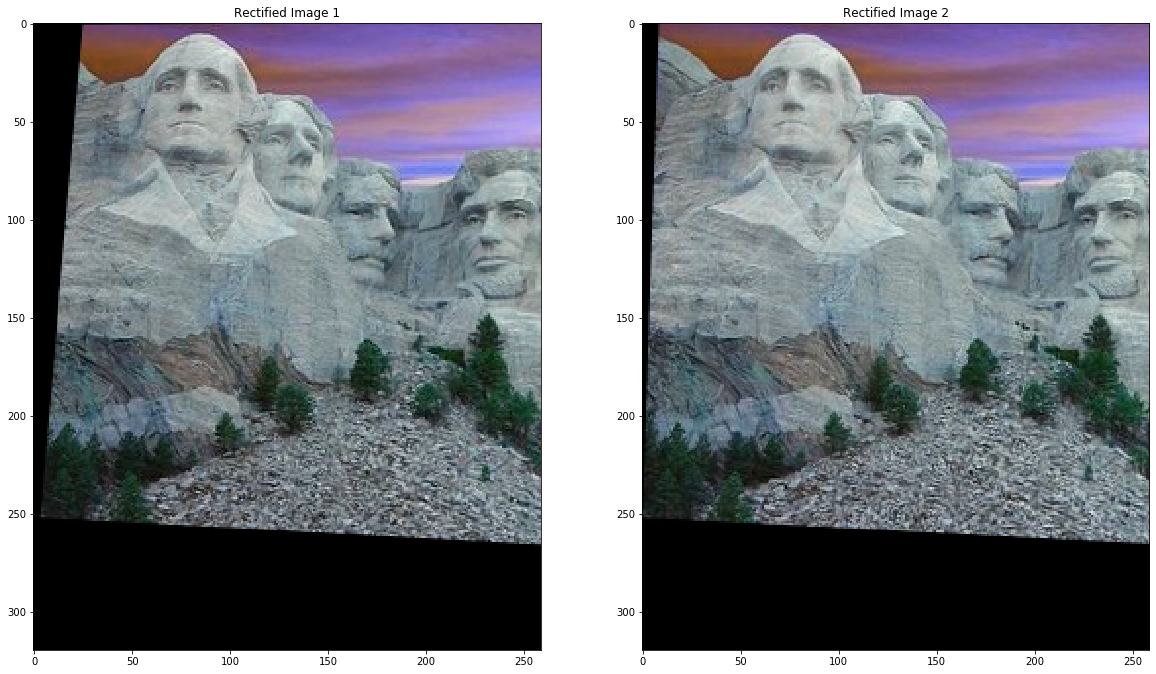

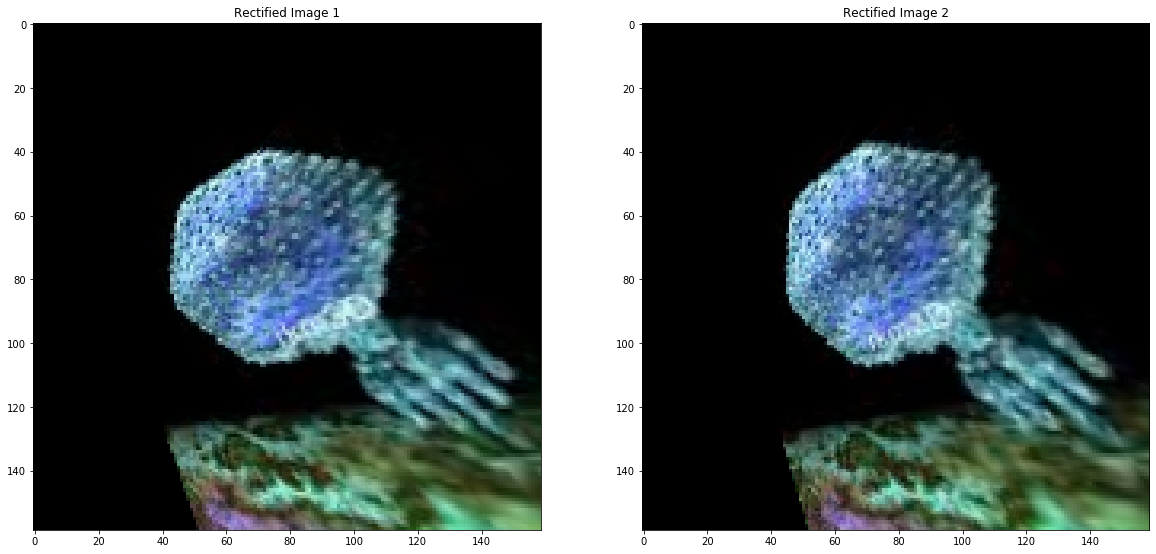

In [59]:
# case1
image = cv2.imread('input_data/stereo_images/1.jpg')
height, width, channel = image.shape

im1 = image[:,:width//2]
im2 = image[:,width//2:]
result_image1, result_image2 = Rectify_Stereo(im1,im2)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,20))
ax1.imshow(result_image1)
ax1.set_title('Rectified Image 1')

ax2.imshow(result_image2)
ax2.set_title('Rectified Image 2')

#case2
image = cv2.imread('input_data/stereo_images/2.jpg')
height, width, channel = image.shape

im1 = image[:,:width//2]
im2 = image[:,width//2:]
result_image3, result_image4 = Rectify_Stereo(im1,im2)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,20))
ax1.imshow(result_image3)
ax1.set_title('Rectified Image 1')

ax2.imshow(result_image4)
ax2.set_title('Rectified Image 2')

#case3
image = cv2.imread('input_data/stereo_images/3.jpeg')
height, width, channel = image.shape

im1 = image[:,:width//2]
im2 = image[:,width//2:]
result_image5, result_image6 = Rectify_Stereo(im1,im2)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,20))
ax1.imshow(result_image5)
ax1.set_title('Rectified Image 1')

ax2.imshow(result_image6)
ax2.set_title('Rectified Image 2')

Text(0.5, 1.0, 'Depth')

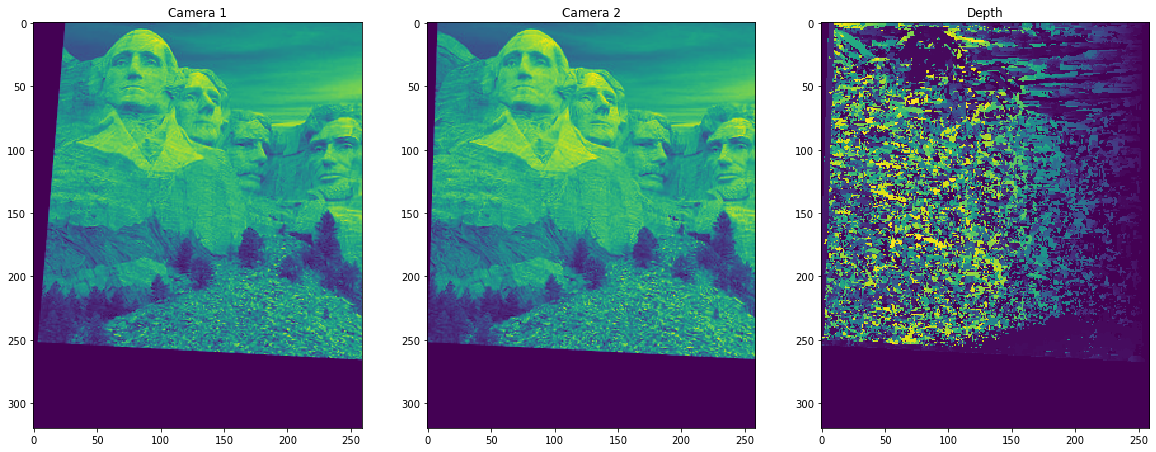

In [60]:
img1 = cv2.cvtColor(result_image3, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(result_image4, cv2.COLOR_BGR2GRAY)
rows, cols = img1.shape[0],img1.shape[1]

k = 5
disparity = np.zeros([rows, cols])
NCC_value = np.zeros([rows, cols])
deeps = np.zeros([rows, cols])

avg_img1 = cv2.blur(img1, (k, k))
avg_img2 = cv2.blur(img2, (k, k))
fimg1 = img1.astype(np.float32)
fimg2 = img2.astype(np.float32)
avg_img1 = avg_img1.astype(np.float32)
avg_img2  = avg_img2.astype(np.float32)
img1_shifted = translaton(fimg1, [k, k])
img2_shifted = translaton(fimg2, [k, k])
img1_sub_avg = img_sub_avg(img1_shifted, avg_img1)
img2_sub_avg = img_sub_avg(img2_shifted, avg_img2)
ncc_max, ncc_d = NCC(img1_sub_avg,img2_sub_avg, threshold = 0.5, max_d = 128)

disp = cv2.normalize(ncc_d, ncc_d, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,
                      dtype=cv2.CV_8U)

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,20))
ax1.imshow(img1)
ax1.set_title('Camera 1')

ax2.imshow(img2)
ax2.set_title('Camera 2')

ax3.imshow(disp)
ax3.set_title('Depth')


### Dynamic Program of stereo

There are two steps for dynamic programming, forward and backward.
Suppose we have a loss matrix for matching row i of the left image and the right image. 
1. For forward step, we start from the top-left corner to the bottom-right corner of the loss matrix. Every element in the loss matrix, for instance ∆(p,q), is the value of the smallest possible total difference accumulated so far from the top-left corner if pth pixel in row i of the left image is matched with qth pixel in row i of the right image. More explicitly, recursive formula is written down. ∆(p, q) = min[∆(p − 1, q), ∆(p, q − 1), ∆(p − 1, q − 1)] + |L(i, p) − R(i, q)|.
2. For backward step, we try to ﬁgure out what’s the matching strategy with the smallest difference. Start from the bottom-right corner and move to the top-left corner of the loss matrix according to the following rules. Suppose we are at (p,q) of the loss matrix. If ∆(p−1,q−1) <= min{∆(p−1,q),∆(p,q−1)}, move upleft. 
3. If ∆(p,q−1) <= min{∆(p−1,q),∆(p−1,q−1)}, move up. 
4. If ∆(p−1,q) <= min{∆(p−1,q−1),∆(p,q−1)}, move left. 
Only when moving up-left, L(i,p) and R(i,q) is matched. When moving left, we claim the pixel in the
right image is occluded. When moving up, we claim the pixel in the left image is occluded.

<img src="dp_algo.png">

In [61]:
def convCPU(matrix, kernel):
    convRes = conv2d(matrix,kernel, mode='same')
    return convRes

def Dynamic_Depth(imageL, imageR):
    
    height = imageL.shape[0]
    width = imageR.shape[1]
    
    start = time.time()
    depthMap = []
    
    # Forward Step
    for line in range(height):
    
        disparityMap = np.zeros((width,40),dtype=np.int16)
    
        for i in range(width):
            for j in range(40): 
                if i+j < 20:
                    disparityMap[i][j] = 0
                elif  i+j > width+20:
                    disparityMap[i][j] = 10000
                elif i > 0 and j > 0 and j < 39 and i+j < width+20 and i+j > 20:
                    disparityMap[i][j] = min(disparityMap[i-1][j],disparityMap[i-1][j+1],disparityMap[i][j-1]) + np.abs(imageL[line][i]-imageR[line][i+j-20])
                elif i > 0 and j == 39 and i+j < width+20 and i+j > 20:
                    disparityMap[i][j] = min(disparityMap[i-1][j],disparityMap[i][j-1]) + np.abs(imageL[line][i]-imageR[line][i+j-20])
                elif i > 0 and j == 0 and i+j < width+20 and i+j > 20:
                    disparityMap[i][j] = min(disparityMap[i-1][j],disparityMap[i-1][j+1]) + np.abs(imageL[line][i]-imageR[line][i+j-20])
                elif i == 0 and i+j < width+20 and i+j > 20:
                    disparityMap[i][j] = disparityMap[i][j-1] + np.abs(imageL[line][i]-imageR[line][i+j-20])
        
        # Backward Step
        startX = 20
        startY = width-1
    
        dispRes = np.ones((width,40))
        
        while startY > 0:
           
            if startX < 39 and startX > 0:
                if disparityMap[startY-1][startX] <= min(disparityMap[startY-1][startX+1], disparityMap[startY][startX-1]):
                    dispRes[startY][startX] = 0
                    startY -= 1
                elif disparityMap[startY-1][startX+1] <= min(disparityMap[startY-1][startX], disparityMap[startY][startX-1]):
                    startX += 1
                    startY -= 1
                elif disparityMap[startY][startX-1] <= min(disparityMap[startY-1][startX+1], disparityMap[startY-1][startX]):
                    startX -= 1
            elif startX == 0:
                if disparityMap[startY-1][startX] <= (disparityMap[startY-1][startX+1]):
                    dispRes[startY][startX] = 0
                    startY -= 1
                elif disparityMap[startY-1][startX+1] <= (disparityMap[startY-1][startX]):
                    startX += 1
                    startY -= 1
            elif startX == 39:
                if disparityMap[startY-1][startX] <= disparityMap[startY][startX-1]:
                    dispRes[startY][startX] = 0
                    startY -= 1
                elif disparityMap[startY][startX-1] <= disparityMap[startY-1][startX]:
                    startX -= 1
       
    
        depthMap1 = []
    
        for i in range(width):
            try:
                col = list(dispRes[i]).index(0)
                depthMap1.append(abs(col-20))
            except:
                depthMap1.append(0)
    
        depthMap.append(depthMap1)
    print("execution time", time.time()-start)
    depthMap = np.array(depthMap).astype(np.int16)
    depthMap = depthMap*255//np.max(depthMap)

    return depthMap

In [62]:
image = cv2.imread('input_data/stereo_images/1.jpg')
height, width, channel = image.shape

im1 = image[:,:width//2]
im2 = image[:,width//2:]
result_image1, result_image2 = Rectify_Stereo(im1,im2)

img1 = cv2.cvtColor(result_image1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(result_image2, cv2.COLOR_BGR2GRAY)
rows, cols = img1.shape[0],img1.shape[1]

k = 7
disparity = np.zeros([rows, cols])
NCC_value = np.zeros([rows, cols])
deeps = np.zeros([rows, cols])

avg_img1 = cv2.blur(img1, (k, k))
avg_img2 = cv2.blur(img2, (k, k))
fimg1 = img1.astype(np.float32)
fimg2 = img2.astype(np.float32)
avg_img1 = avg_img1.astype(np.float32)
avg_img2  = avg_img2.astype(np.float32)
img1_shifted = translaton(fimg1, [k, k])
img2_shifted = translaton(fimg2, [k, k])
img1_sub_avg = img_sub_avg(img1_shifted, avg_img1)
img2_sub_avg = img_sub_avg(img2_shifted, avg_img2)
ncc_max, ncc_d = NCC(img1_sub_avg,img2_sub_avg, threshold = 0.5, max_d = 128)

disp = cv2.normalize(ncc_d, ncc_d, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,
                      dtype=cv2.CV_8U)

execution time 89.30488061904907


Text(0.5, 1.0, 'Depth of Dynamic Programming')

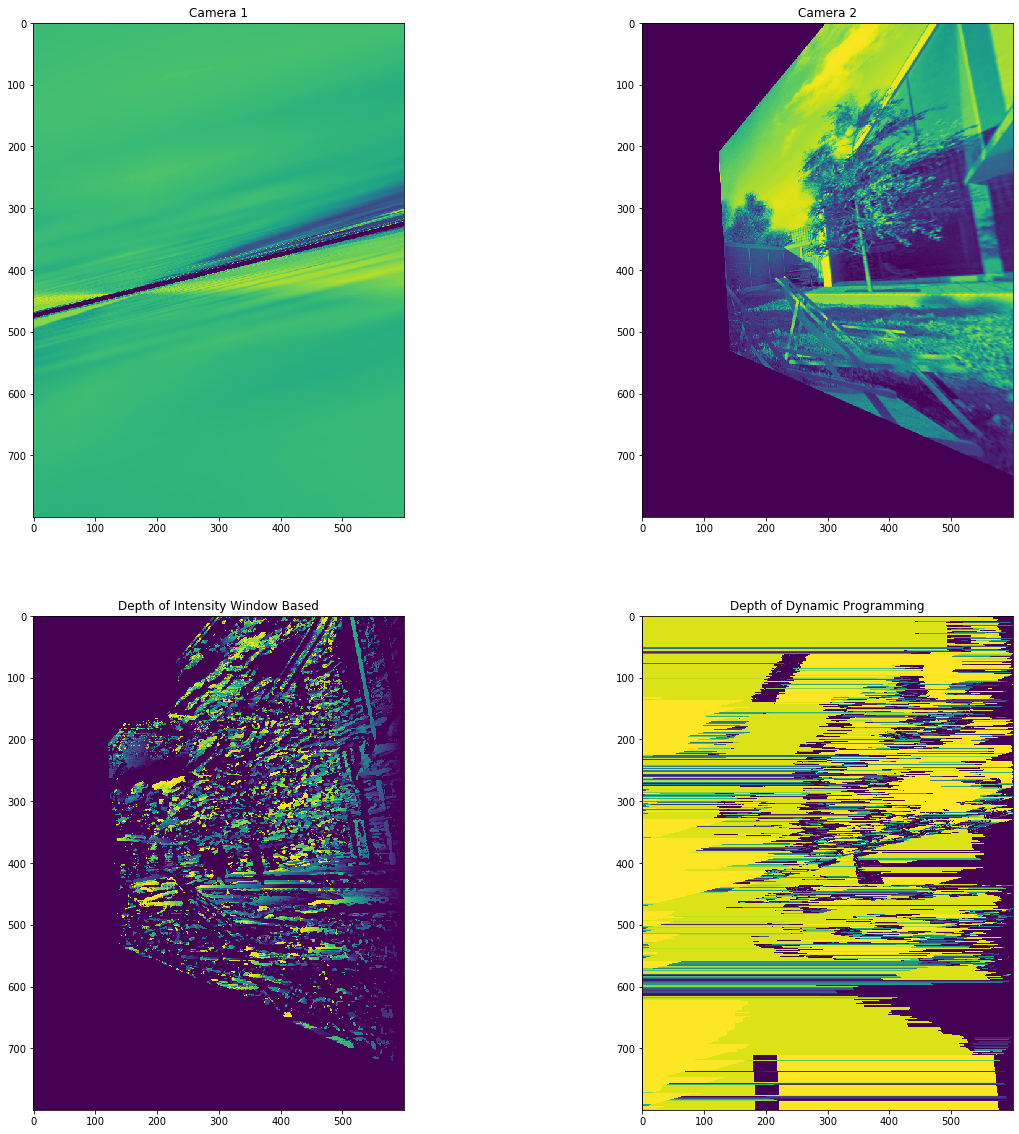

In [63]:
imageL = cv2.cvtColor(result_image1, cv2.COLOR_BGR2GRAY)
imageR = cv2.cvtColor(result_image2, cv2.COLOR_BGR2GRAY)

dynamic = Dynamic_Depth(imageL, imageR)

f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(20,20))
ax1.imshow(imageL)
ax1.set_title('Camera 1')

ax2.imshow(imageR)
ax2.set_title('Camera 2')

ax3.imshow(disp)
ax3.set_title('Depth of Intensity Window Based')

ax4.imshow(dynamic)
ax4.set_title('Depth of Dynamic Programming')

### Dense SIFT Matching and Correlation based Matching

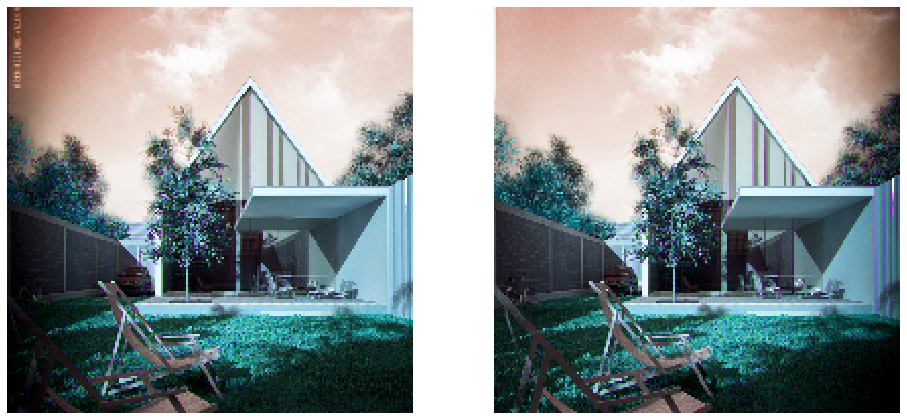

Checking Keypoinys 4800
Found Matches: 500


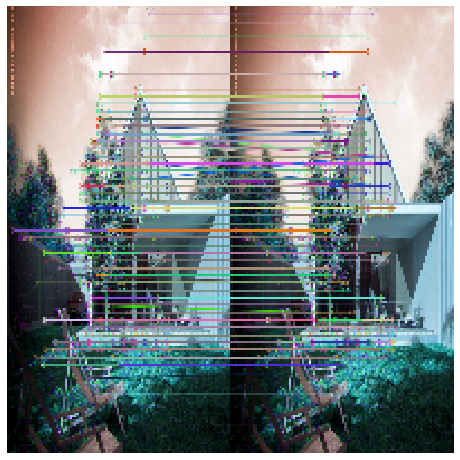

Text(0.5, 1.0, 'Dense SIFT Matching')

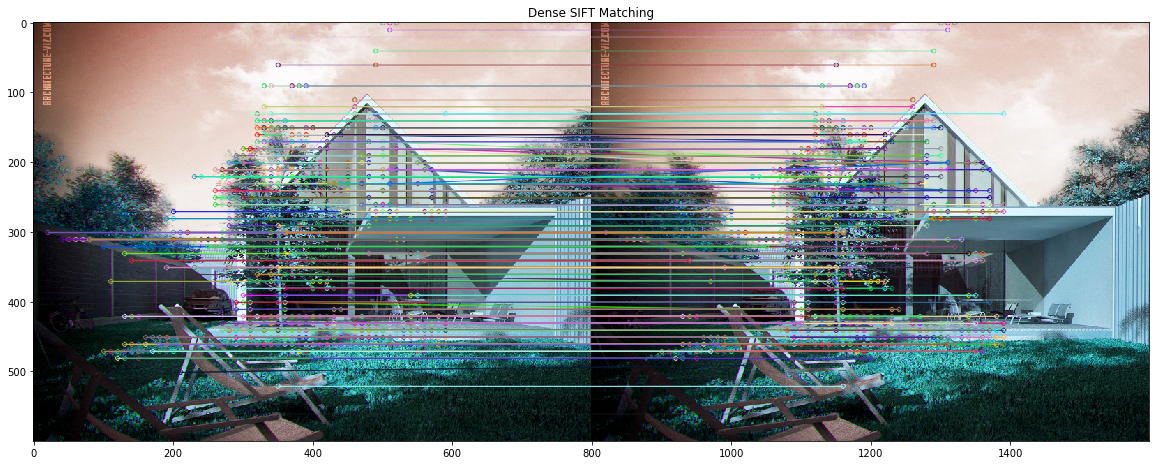

In [76]:
def display_images(img_list, shape,fig_size=(16,16),is_gray=None):    
    if is_gray is None:
        is_gray = np.zeros(shape)
    
    m,n = shape
    fig = plt.figure(figsize=fig_size)
    
    for i in range(m):
        for j in range(n):
            ax = fig.add_subplot(m,n,i*n + j+1)
            if is_gray[i,j] == 1:
                ax.imshow(img_list[i][j],cmap='gray')
            else:
                img_list[i][j] = cv2.resize(img_list[i][j],(200,200))
                ax.imshow(img_list[i][j])   
            ax.axis('off')
    plt.show()
    return 

def dense_sift_matching(img1,img2,min_match_cnt=500):
    #     Display the images
    display_images([[img1,img2]],shape=(1,2))
    
    #     Initiliaze CV2 SIFT
    sift = cv2.xfeatures2d.SIFT_create()

    # Define our keypoints

    h,w,c = img1.shape
    kp=[]
    for i in range(1,h,10):
        for j in range(1,w,10):
            kp.append(cv2.KeyPoint(i, j, 3))
    print("Checking Keypoinys",len(kp))
    
    
    #     Taking gray scale images for SIFT
    gray_im1 = cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)
    kp1,des1 = sift.compute(gray_im1,kp)

    gray_im2 = cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
    kp2,des2 = sift.compute(gray_im2,kp)

    # BFMatcher with default params
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(des1,des2)
    matches = sorted(matches, key = lambda x:x.distance)[0:min_match_cnt]
    print("Found Matches:",len(matches))
        
        
    draw_params = dict(matchesMask=None,
                       singlePointColor=None,
                       flags=2)
        
    dis_im = cv2.drawMatches(img1,kp1,img1,kp1,matches,None,**draw_params)
    display_images([[dis_im]],shape=(1,1),fig_size=(8,16))    
    return kp1,des1,kp2,des2,matches,dis_im


img = cv2.imread('input_data/stereo_images/1.jpg')
h,w,c = img.shape
img1 = img[:,0:w//2]
img2 = img[:,w//2:w]
sift_param = dense_sift_matching(img1,img2)
f, (ax1) = plt.subplots(1,1,figsize=(20,20))
ax1.imshow(sift_param[-1])
ax1.set_title('Dense SIFT Matching')


In [77]:
def corr(v1,v2):
    return v1.T.dot(v2)/(np.sqrt(v1.T.dot(v1))*np.sqrt(v2.T.dot(v2)))

def correlation_matching(img1,img2,window_size=128,stride=128,thresh = 0.01):
    h1,w1,c = img1.shape
    h2,w2,c = img2.shape
    
    #Pass through all the patches in img1 and find patch in img2 with least 
    best_matches = []
    for y1 in range(0,h1-window_size,stride):
        for x1 in range(0,w1-window_size,stride):
            least_dis = 1.0
            for y2 in range(0,h2-window_size,stride):
                for x2 in range(0,w2-window_size,stride):
                    v1 = img1[y1:y1+window_size, x1:x1+window_size,:].flatten()
                    v2 = img2[y2:y2+window_size, x2:x2+window_size,:].flatten()
                    dis = corr(v1,v2)
                    if least_dis > dis:
                        least_dis = dis
                        least_coord = [x1,y1,x2,y2,dis]
            best_matches.append(least_coord)
    return best_matches


def draw_matches(img,matches,window_size=128):
    h,w,c = img.shape
    for match in matches:
        pt1 = (match[1]+window_size//2,match[0]+window_size//2)
        pt2 = (match[3]+window_size//2+w//2,match[2]+ window_size//2)
        line_img = cv2.line(img,pt1,pt2,(0,225,225),3)
    
    display_images([[line_img]],shape=(1,1))
    return line_img


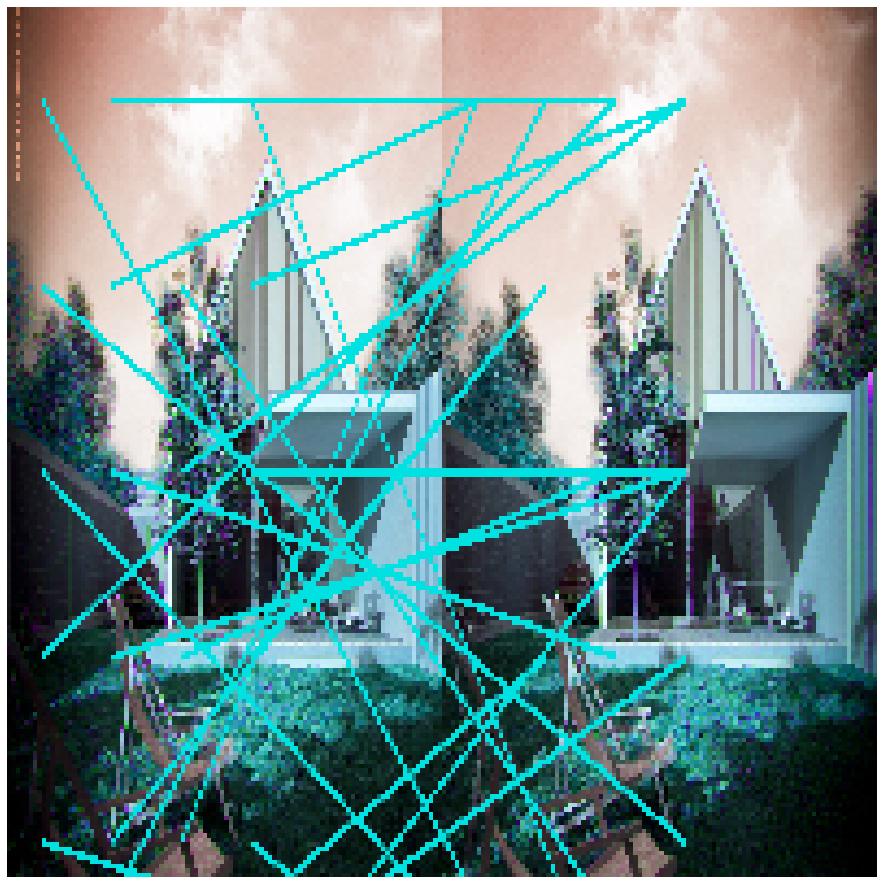

Text(0.5, 1.0, 'Correlation Matching')

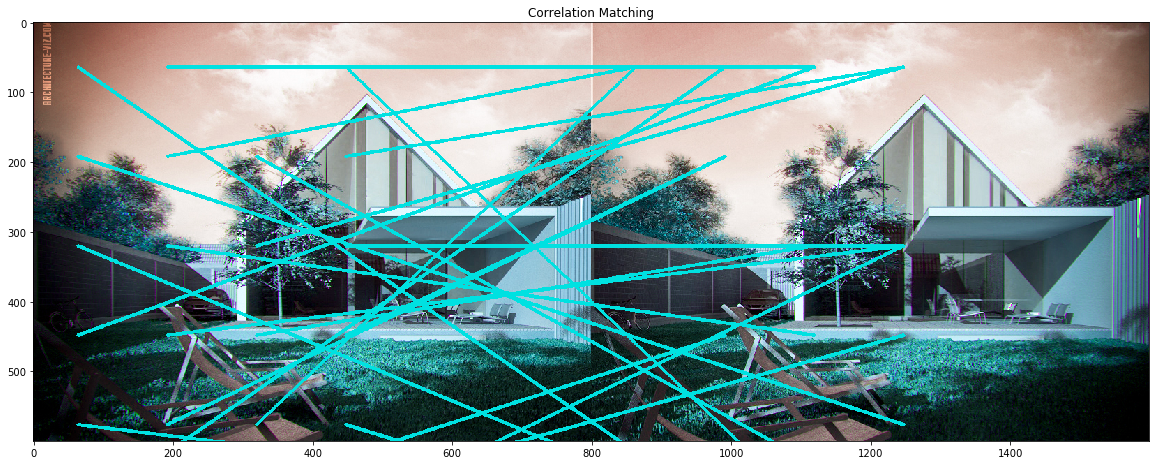

In [78]:
img = cv2.imread('input_data/stereo_images/1.jpg')
h,w,c = img.shape
img1 = img[:,0:w//2]
img2 = img[:,w//2:w]
matches = correlation_matching(img1,img2)
dis_im = draw_matches(img,matches)
f, (ax1) = plt.subplots(1,1,figsize=(20,20))
ax1.imshow(dis_im)
ax1.set_title('Correlation Matching')

We can clearly notice matching using SIFT discriptors gives much better reslts than naive correlation based matching. High error in correlation based method is because a scene can have many similiar patches. In case of stereo cameraa, their is a small offset in the camera location. This leads to the same scene having different pixel values for a patch trying to represent the same scene